In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from keras.losses import BinaryFocalCrossentropy
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [2]:
DATA_DIR = r"C:\Users\prasi\Downloads\Flood satellite imagery\Water Bodies Dataset"
IMG_DIR  = os.path.join(DATA_DIR, "Images")
MSK_DIR  = os.path.join(DATA_DIR, "Masks")

# collect all file‑pairs
all_images = sorted(glob.glob(os.path.join(IMG_DIR, "*.jpg")))
all_masks  = sorted(glob.glob(os.path.join(MSK_DIR, "*.jpg")))
print(f"Found {len(all_images)} images and {len(all_masks)} masks.")

Found 2841 images and 2841 masks.


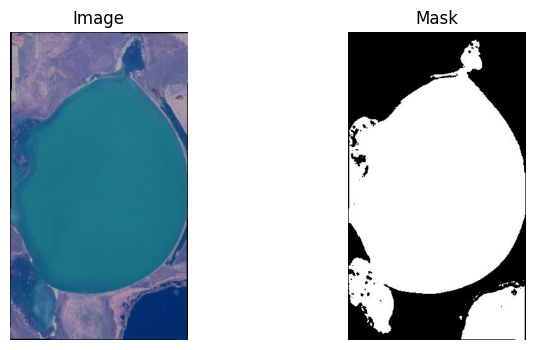

In [3]:
def show_sample(idx):
    img = plt.imread(all_images[idx])
    m   = plt.imread(all_masks[idx])
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1); plt.title("Image"); plt.imshow(img); plt.axis("off")
    plt.subplot(1,2,2); plt.title("Mask");  plt.imshow(m, cmap="gray"); plt.axis("off")
    plt.savefig("sample_img.jpg", dpi=300)
    
show_sample(10)

In [4]:
# Split your data (80-10-10 split as an example)
split_1 = int(0.8 * len(all_images))
split_2 = int(0.9 * len(all_images))

train_images = all_images[:split_1]
train_masks  = all_masks[:split_1]

val_images = all_images[split_1:split_2]
val_masks  = all_masks[split_1:split_2]

test_images = all_images[split_2:]
test_masks  = all_masks[split_2:]

# Set image size and batch size
IMG_SIZE = 128
BATCH_SIZE = 16

# Preprocessing function
def preprocess(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)

    msk = tf.io.read_file(mask_path)
    msk = tf.image.decode_jpeg(msk, channels=1)

    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    msk = tf.image.resize(msk, [IMG_SIZE, IMG_SIZE], method="nearest")

    img = tf.cast(img, tf.float32) / 255.0
    msk = tf.cast(msk, tf.float32) / 255.0        # normalize 0–255 to 0–1
    msk = tf.cast(tf.round(msk), tf.int32) 

    '''msk = tf.cast(msk, tf.uint8)  # or tf.int32
'''
    '''msk = tf.cast(msk, tf.float32) / 255.0
    msk = tf.round(msk)  # binary mask'''

    return img, msk

# Dataset preparation function
def prepare(images, masks, batch=BATCH_SIZE):
    ds = tf.data.Dataset.from_tensor_slices((images, masks))
    ds = (ds
          .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
          .cache()
          .batch(batch)
          .prefetch(tf.data.AUTOTUNE))
    return ds

# Prepare datasets
train_ds = prepare(train_images, train_masks)
val_ds   = prepare(val_images, val_masks)
test_ds  = prepare(test_images, test_masks)


In [5]:
def attention_gate(x, g, inter_channels):
    """
    Attention Gate: takes encoder feature-map x and decoder gating signal g.
    Returns x multiplied by attention coefficients.
    """
    # 1x1 convs to bring to same channel dimension
    theta_x = layers.Conv2D(inter_channels, kernel_size=1, strides=1, padding='same')(x)
    phi_g   = layers.Conv2D(inter_channels, kernel_size=1, strides=1, padding='same')(g)
    
    # Add & ReLU
    add_xg = layers.add([theta_x, phi_g])
    act_xg = layers.Activation('relu')(add_xg)
    
    # 1x1 conv + sigmoid to get attention map
    psi = layers.Conv2D(1, kernel_size=1, strides=1, padding='same')(act_xg)
    sigmoid_psi = layers.Activation('sigmoid')(psi)
    
    # Multiply attention coefficients back onto the skip-connection feature map
    upsample_psi = layers.UpSampling2D(size=(1,1))(sigmoid_psi)  # shape matches x
    gated_x = layers.multiply([x, upsample_psi])
    
    return gated_x

def unet_with_attention(input_size=(IMG_SIZE,IMG_SIZE,3)):
    inputs = layers.Input(input_size)
    # Encoder
    c1 = layers.Conv2D(32,3,padding="same", activation="relu")(inputs)
    c1 = layers.Conv2D(32,3,padding="same", activation="relu")(c1)
    p1 = layers.MaxPool2D()(c1)

    c2 = layers.Conv2D(64,3,padding="same", activation="relu")(p1)
    c2 = layers.Conv2D(64,3,padding="same", activation="relu")(c2)
    p2 = layers.MaxPool2D()(c2)

    c3 = layers.Conv2D(128,3,padding="same", activation="relu")(p2)
    c3 = layers.Conv2D(128,3,padding="same", activation="relu")(c3)
    p3 = layers.MaxPool2D()(c3)

    # Bottleneck
    b = layers.Conv2D(256,3,padding="same", activation="relu")(p3)
    b = layers.Conv2D(256,3,padding="same", activation="relu")(b)

    # Decoder + Attention Gates on skip-connections
    u3 = layers.Conv2DTranspose(128,2,strides=2, padding="same")(b)
    # apply AG to c3 with gating signal u3
    c3_att = attention_gate(c3, u3, inter_channels=64)
    u3 = layers.concatenate([u3, c3_att])
    c4 = layers.Conv2D(128,3,padding="same", activation="relu")(u3)
    c4 = layers.Conv2D(128,3,padding="same", activation="relu")(c4)

    u4 = layers.Conv2DTranspose(64,2,strides=2, padding="same")(c4)
    c2_att = attention_gate(c2, u4, inter_channels=32)
    u4 = layers.concatenate([u4, c2_att])
    c5 = layers.Conv2D(64,3,padding="same", activation="relu")(u4)
    c5 = layers.Conv2D(64,3,padding="same", activation="relu")(c5)

    u5 = layers.Conv2DTranspose(32,2,strides=2, padding="same")(c5)
    c1_att = attention_gate(c1, u5, inter_channels=16)
    u5 = layers.concatenate([u5, c1_att])
    c6 = layers.Conv2D(32,3,padding="same", activation="relu")(u5)
    c6 = layers.Conv2D(32,3,padding="same", activation="relu")(c6)

    outputs = layers.Conv2D(1,1,activation="sigmoid")(c6)
    return Model(inputs, outputs)

# Dice Coefficient Metric
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  # Threshold predictions to binary
    
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice


# Instantiate and compile
model = unet_with_attention()
model.compile(
    optimizer='adam',
    loss=BinaryFocalCrossentropy(gamma=2.0, alpha=0.25),
    metrics=['accuracy', dice_coef]
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │    131,200 │ conv2d_7[0][0]    │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │      8,256 │ conv2d_5[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │      8,256 │ conv2d_transpose… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ conv2d_8[0][0],   │
│                     │ 64)               │            │ conv2d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 32, 32,    │          0 │ add[0][0]       

 Total params: 1,947,444 (7.43 MB)

 Trainable params: 1,947,444 (7.43 MB)

 Non-trainable params: 0 (0.00 B)

129m 47.3 s

In [6]:
EPOCHS = 50

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

# Check what metrics are available
print("Available metrics:", history.history.keys())

# Extract metrics
final_train_loss = history.history['loss'][-1]
final_val_loss   = history.history['val_loss'][-1]

final_train_acc  = history.history['accuracy'][-1]
final_val_acc    = history.history['val_accuracy'][-1]

# Dice metric history key matches the function name
final_train_dice = history.history['dice_coef'][-1]
final_val_dice   = history.history['val_dice_coef'][-1]

print(f"\nFinal Results after {EPOCHS} Epochs")
print(f"Train Loss:     {final_train_loss:.4f}")
print(f"Val Loss:       {final_val_loss:.4f}")
print(f"Train Accuracy: {final_train_acc:.4f}")
print(f"Val Accuracy:   {final_val_acc:.4f}")
print(f"Train Dice:     {final_train_dice:.4f}")
print(f"Val Dice:       {final_val_dice:.4f}")


Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - accuracy: 0.7006 - dice_coef: 0.2481 - loss: 0.1496 - val_accuracy: 0.7467 - val_dice_coef: 0.5447 - val_loss: 0.1373
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 0.7630 - dice_coef: 0.5718 - loss: 0.1325 - val_accuracy: 0.7508 - val_dice_coef: 0.4943 - val_loss: 0.1346
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.7667 - dice_coef: 0.6007 - loss: 0.1289 - val_accuracy: 0.7629 - val_dice_coef: 0.5742 - val_loss: 0.1293
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - accuracy: 0.7755 - dice_coef: 0.6103 - loss: 0.1244 - val_accuracy: 0.7689 - val_dice_coef: 0.6000 - val_loss: 0.1283
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - accuracy: 0.7707 - dice_coef: 0.5768 - loss: 0.1231 - val_accuracy: 0.7731 - val_dice_coef: 0.6241 - val_loss: 0.1272
Epoch 6/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.7862 - dice_coef: 0.6317 - loss: 0.1219 - val_accuracy: 0.7418 - val

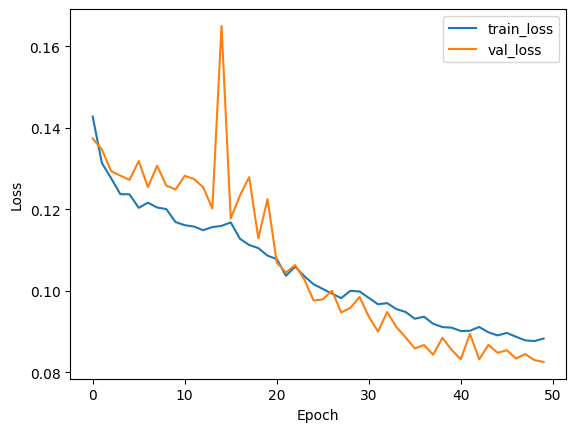

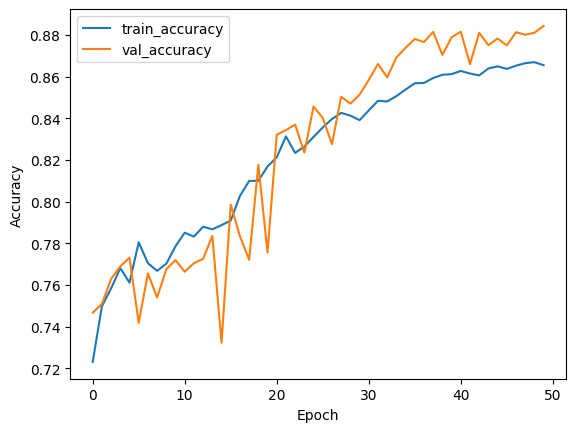

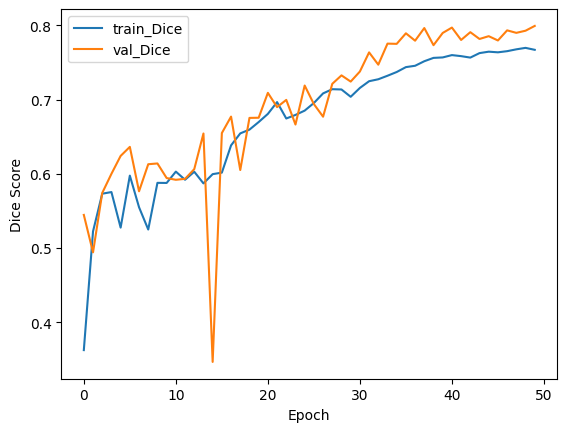

In [7]:
# 1) Loss curve
plt.figure()
plt.plot(history.history["loss"],     label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig("loss_curve_attention_unet.png", dpi=300)
plt.show()

# 2) Accuracy curve
plt.figure()
plt.plot(history.history["accuracy"],      label="train_accuracy")
plt.plot(history.history["val_accuracy"],  label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("accuracy_curve_attention_unet.png", dpi=300)
plt.show()

# 3) Dice Score curve
plt.figure()
plt.plot(history.history["dice_coef"],     label="train_Dice")
plt.plot(history.history["val_dice_coef"], label="val_Dice")
plt.xlabel("Epoch")
plt.ylabel("Dice Score")
plt.legend()
plt.savefig("dice_curve.png", dpi=300)
plt.show()


In [8]:
# If you compiled with metrics=['accuracy', dice_coef], then evaluate returns:
#    [loss, accuracy, dice_coef]
loss, accuracy, dice = model.evaluate(test_ds)

print(f"Test Loss:     {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Dice:     {dice:.4f}")


18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 318ms/step - accuracy: 0.8860 - dice_coef: 0.8053 - loss: 0.0802
Test Loss:     0.0795
Test Accuracy: 0.8844
Test Dice:     0.8091


9.5 s

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step


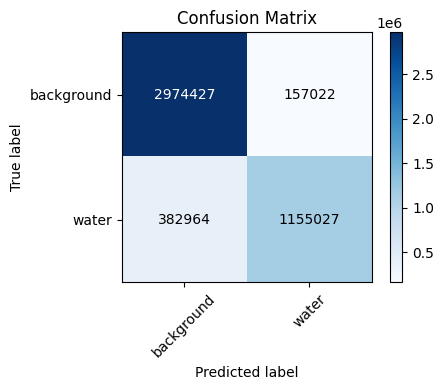

<Figure size 640x480 with 0 Axes>

In [9]:
# Build y_true, y_pred lists as before…
# (no changes here)

y_true, y_pred = [], []
for imgs, masks in test_ds:
    preds = (model.predict(imgs) > 0.5).astype(int)
    y_pred.append(preds.ravel())
    y_true.append(masks.numpy().ravel())

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)


cm = confusion_matrix(y_true, y_pred)
classes = ["background", "water"]

plt.figure(figsize=(5,4))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()
ticks = np.arange(len(classes))
plt.xticks(ticks, classes, rotation=45)
plt.yticks(ticks, classes)

thresh = cm.max() / 2
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, cm[i,j], ha="center", va="center",
             color="white" if cm[i,j] > thresh else "black")

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()
plt.savefig("confusion_matrix_attention_unet.jpg", dpi=300)


Test ROC AUC: 0.9258


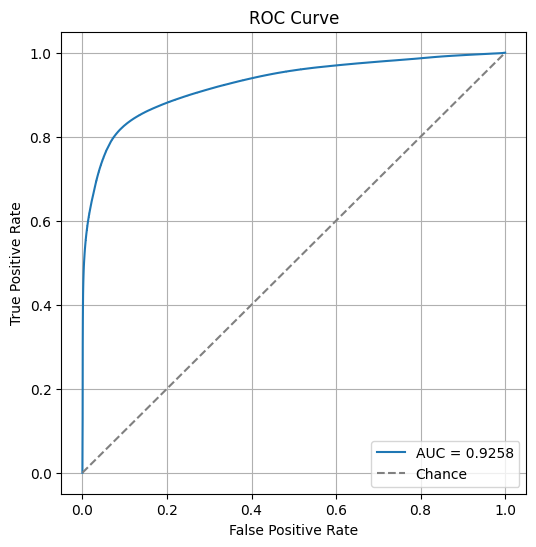

<Figure size 640x480 with 0 Axes>

In [10]:


# 1) Gather probabilities & labels
y_true, y_prob = [], []
for imgs, masks in test_ds:
    probs = model.predict(imgs, verbose=0)[...,0]  # (batch, H, W)
    y_prob.append(probs.ravel())
    y_true.append(masks.numpy().ravel())

y_prob = np.concatenate(y_prob)
y_true = np.concatenate(y_true)

# 2) Compute ROC metrics
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
auc = roc_auc_score(y_true, y_prob)
print(f"Test ROC AUC: {auc:.4f}")

# 3) Plot the ROC curve
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0,1], [0,1], linestyle="--", color="gray", label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
plt.savefig("auc_attention_unet.jpg", dpi=300)


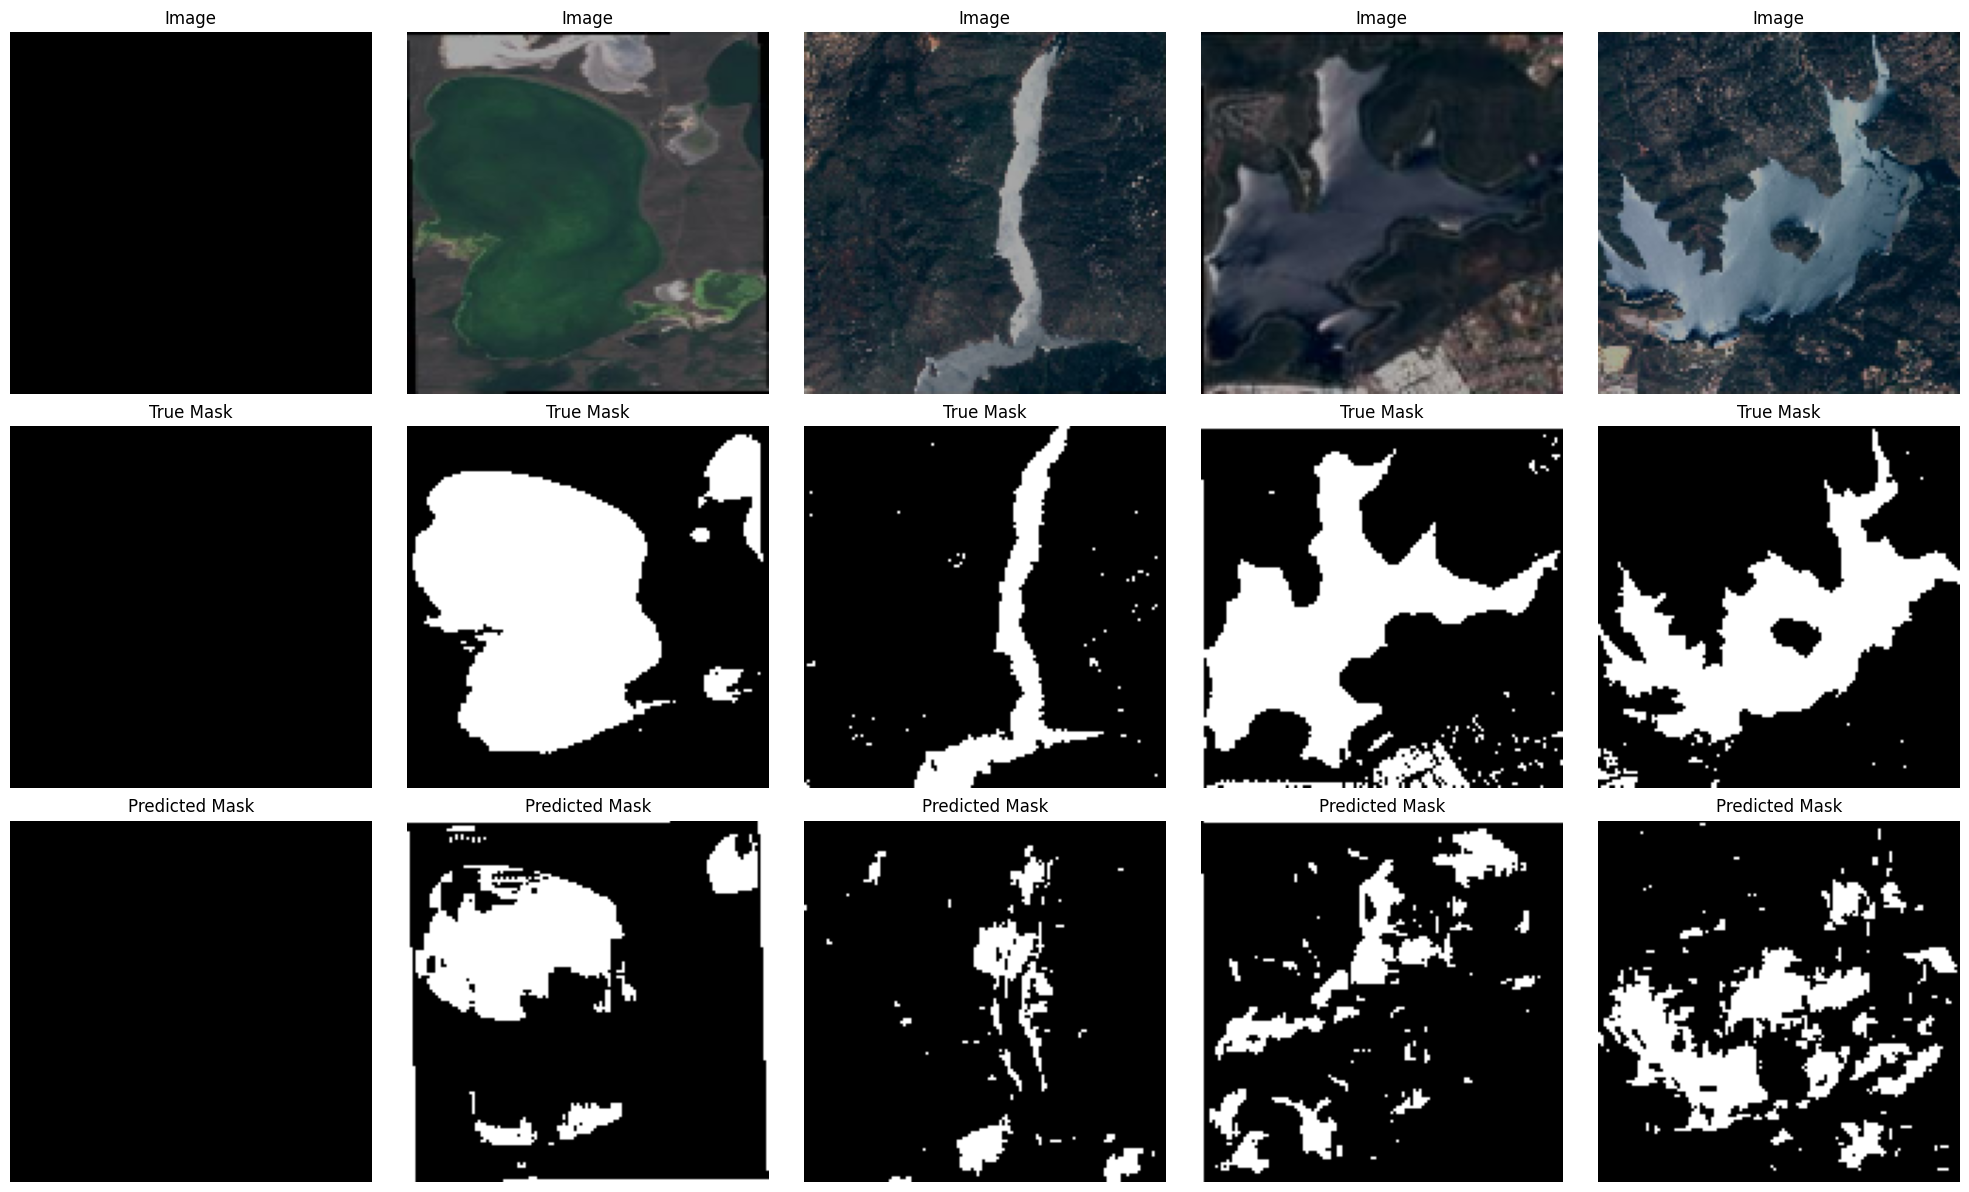

<Figure size 640x480 with 0 Axes>

In [11]:
def visualize_test_predictions(dataset, model, num_examples=5):
    """
    Displays `num_examples` samples from `dataset` with:
      - Left:  input image
      - Center: ground-truth mask
      - Right: predicted mask (thresholded 0.5)
    """
    # Unbatch so we can take individual samples
    ds = dataset.unbatch().batch(1)
    
    plt.figure(figsize=(num_examples * 4, 3 * 4))
    
    for i, (img_batch, mask_batch) in enumerate(ds.take(num_examples)):
        # img_batch: (1, H, W, 3), mask_batch: (1, H, W, 1)
        img  = img_batch[0].numpy()
        true = mask_batch[0,...,0].numpy()
        
        # Predict on this single image
        pred_prob = model.predict(img_batch, verbose=0)[0,...,0]
        pred = (pred_prob > 0.5).astype(np.uint8)
        
        # Plot input image
        ax = plt.subplot(3, num_examples, i+1)
        ax.imshow(img)
        ax.set_title("Image")
        ax.axis("off")
        
        # Plot true mask
        ax = plt.subplot(3, num_examples, num_examples + i+1)
        ax.imshow(true, cmap="gray")
        ax.set_title("True Mask")
        ax.axis("off")
        
        # Plot predicted mask
        ax = plt.subplot(3, num_examples, 2*num_examples + i+1)
        ax.imshow(pred, cmap="gray")
        ax.set_title("Predicted Mask")
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()
    plt.savefig("output_attention_unet.jpg", dpi=300)

# Usage: show 5 examples from your test set
visualize_test_predictions(test_ds, model, num_examples=5)
